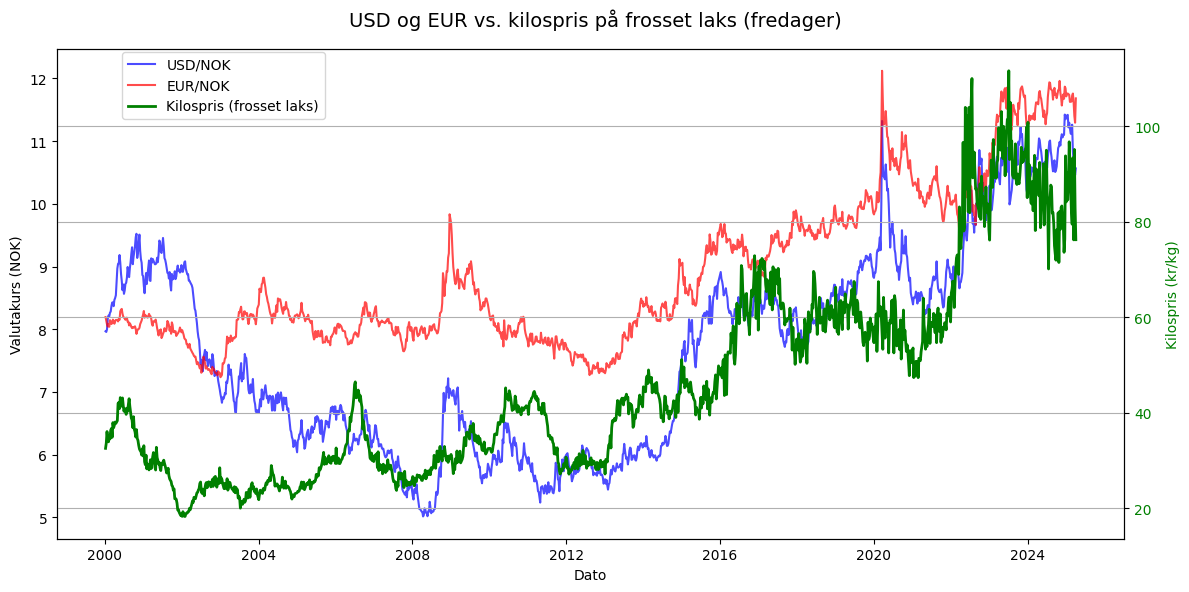


KORRELASJONER (frosset laks):
EUR/NOK og kilospris: 0.8691817958940623
USD/NOK og kilospris: 0.7444588740765478


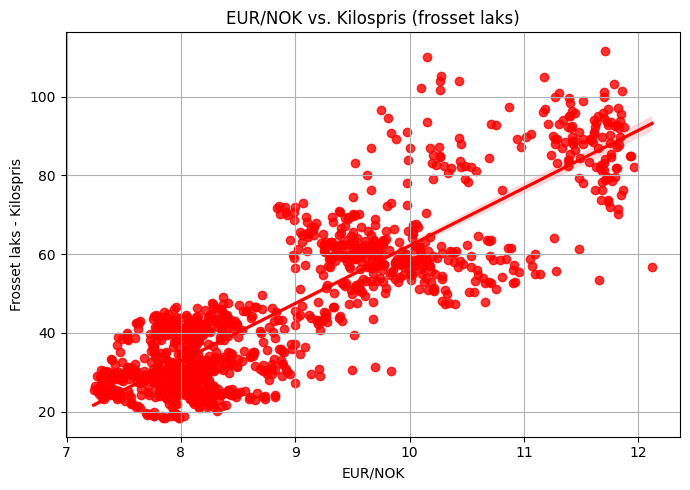

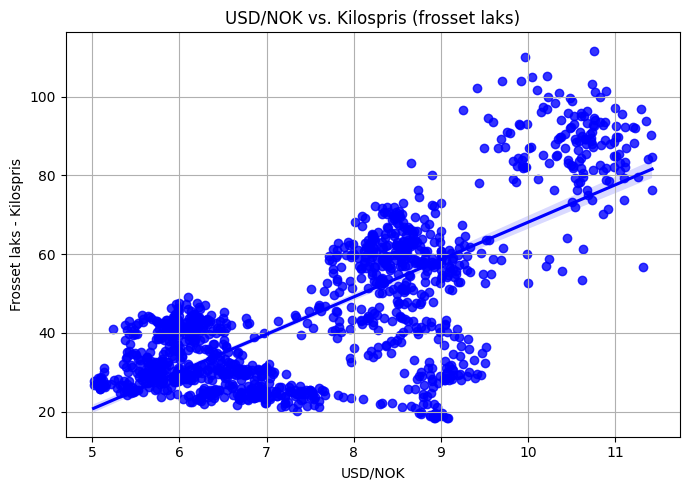

In [ ]:
# Visualisering 1 og 2: linjediagram og scatterplot

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Henter valutakurs (kun fredager)
def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]

# 2. Henter eksportdata (SSB tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 3. Analyse – for frosset laks
def analyser_frosset_laks():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()

    # Sammenstilling
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Frosset laks - Kilospris"]], on="UkeID")
    df = df.dropna()

    # ---------- 1: Plot ----------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df["Dato"], df["USD/NOK"], label="USD/NOK", color="blue", alpha=0.7)
    ax1.plot(df["Dato"], df["EUR/NOK"], label="EUR/NOK", color="red", alpha=0.7)
    ax1.set_ylabel("Valutakurs (NOK)")
    ax1.set_xlabel("Dato")

    ax2 = ax1.twinx()
    ax2.plot(df["Dato"], df["Frosset laks - Kilospris"], label="Kilospris (frosset laks)", color="green", linewidth=2)
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle("USD og EUR vs. kilospris på frosset laks (fredager)", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- 2: Korrelasjoner ----------
    print("\nKORRELASJONER (frosset laks):")
    print("EUR/NOK og kilospris:", df["EUR/NOK"].corr(df["Frosset laks - Kilospris"]))
    print("USD/NOK og kilospris:", df["USD/NOK"].corr(df["Frosset laks - Kilospris"]))

    # ---------- 3: Scatterplots ----------
    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="EUR/NOK", y="Frosset laks - Kilospris", color="red")
    plt.title("EUR/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="USD/NOK", y="Frosset laks - Kilospris", color="blue")
    plt.title("USD/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    analyser_frosset_laks()

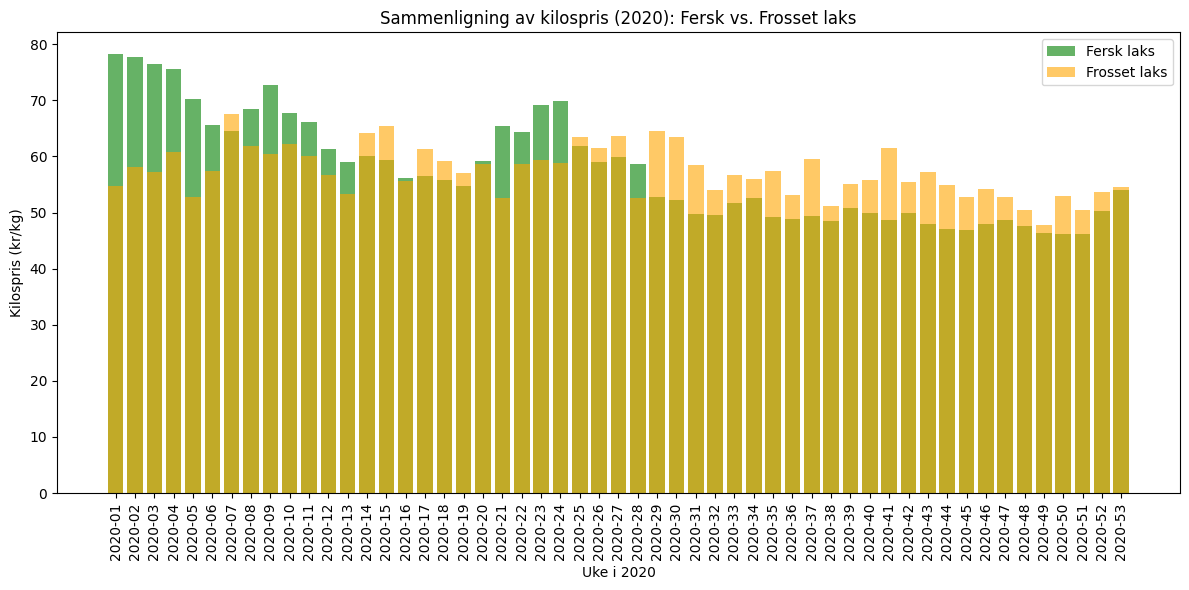

In [ ]:
# Visualisering nr. 3: Søylediagram for sammenligning av fersk og frosset laks i 2020

import requests
import pandas as pd
import matplotlib.pyplot as plt

# 1. Hent eksportdata fra SSB (tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 2. Søylediagram for sammenligning av fersk og frosset laks i 2020
def sammenlign_fersk_frosset():
    df = hent_eksportdata()

    # Filtrer dataene for 2020
    df_2020 = df[df["År og ukenr."].str.contains("2020")]
    
    # Plot søylediagram
    plt.figure(figsize=(12, 6))
    plt.bar(df_2020["UkeID"], df_2020["Fersk laks - Kilospris"], label="Fersk laks", color="green", alpha=0.6)
    plt.bar(df_2020["UkeID"], df_2020["Frosset laks - Kilospris"], label="Frosset laks", color="orange", alpha=0.6)
    
    plt.xlabel("Uke i 2020")
    plt.ylabel("Kilospris (kr/kg)")
    plt.title("Sammenligning av kilospris (2020): Fersk vs. Frosset laks")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Kjør funksjonen
sammenlign_fersk_frosset()


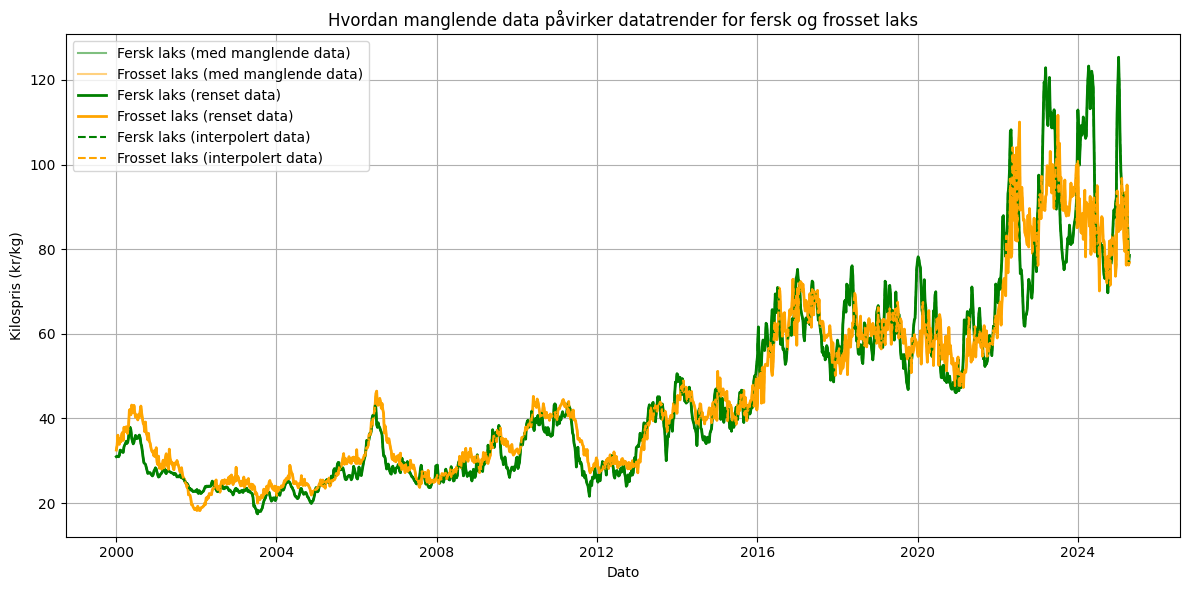

In [ ]:
# Håndtere manglende data

# 1. Henter eksportdata fra SSB (tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 2. Graf som viser hvordan manglende data påvirker trenden
def manglende_data_påvirkning():
    df = hent_eksportdata()

    # Konverter ukeID til mandagsdato i hver uke
    df["UkeDato"] = pd.to_datetime(df["UkeID"] + "-1", format="%Y-%W-%w")

    # Del opp datasettet i to versjoner:
    # 1. Originalt datasett (med manglende verdier)
    df_original = df.copy()

    # 2. Renset datasett (fjernet manglende data)
    df_renset = df.dropna()

    # 3. Interpolert datasett (fyller manglende verdier med interpolasjon)
    df_interpolert = df.copy()
    df_interpolert["Fersk laks - Kilospris"] = df_interpolert["Fersk laks - Kilospris"].interpolate()
    df_interpolert["Frosset laks - Kilospris"] = df_interpolert["Frosset laks - Kilospris"].interpolate()

    # Plot graf for sammenligning
    plt.figure(figsize=(12, 6))

    # Originaldata (med manglende verdier)
    plt.plot(df_original["UkeDato"], df_original["Fersk laks - Kilospris"], label="Fersk laks (med manglende data)", color="green", alpha=0.5)
    plt.plot(df_original["UkeDato"], df_original["Frosset laks - Kilospris"], label="Frosset laks (med manglende data)", color="orange", alpha=0.5)
    
    # Renset data (uten manglende verdier)
    plt.plot(df_renset["UkeDato"], df_renset["Fersk laks - Kilospris"], label="Fersk laks (renset data)", color="green", linewidth=2)
    plt.plot(df_renset["UkeDato"], df_renset["Frosset laks - Kilospris"], label="Frosset laks (renset data)", color="orange", linewidth=2)

    # Interpolert data (med interpolasjon for manglende verdier)
    plt.plot(df_interpolert["UkeDato"], df_interpolert["Fersk laks - Kilospris"], label="Fersk laks (interpolert data)", color="green", linestyle="--")
    plt.plot(df_interpolert["UkeDato"], df_interpolert["Frosset laks - Kilospris"], label="Frosset laks (interpolert data)", color="orange", linestyle="--")

    # Legg til akser og tittel
    plt.xlabel("Dato")
    plt.ylabel("Kilospris (kr/kg)")
    plt.title("Hvordan manglende data påvirker datatrender for fersk og frosset laks")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Kjør funksjonen for manglende data påvirkning
manglende_data_påvirkning()


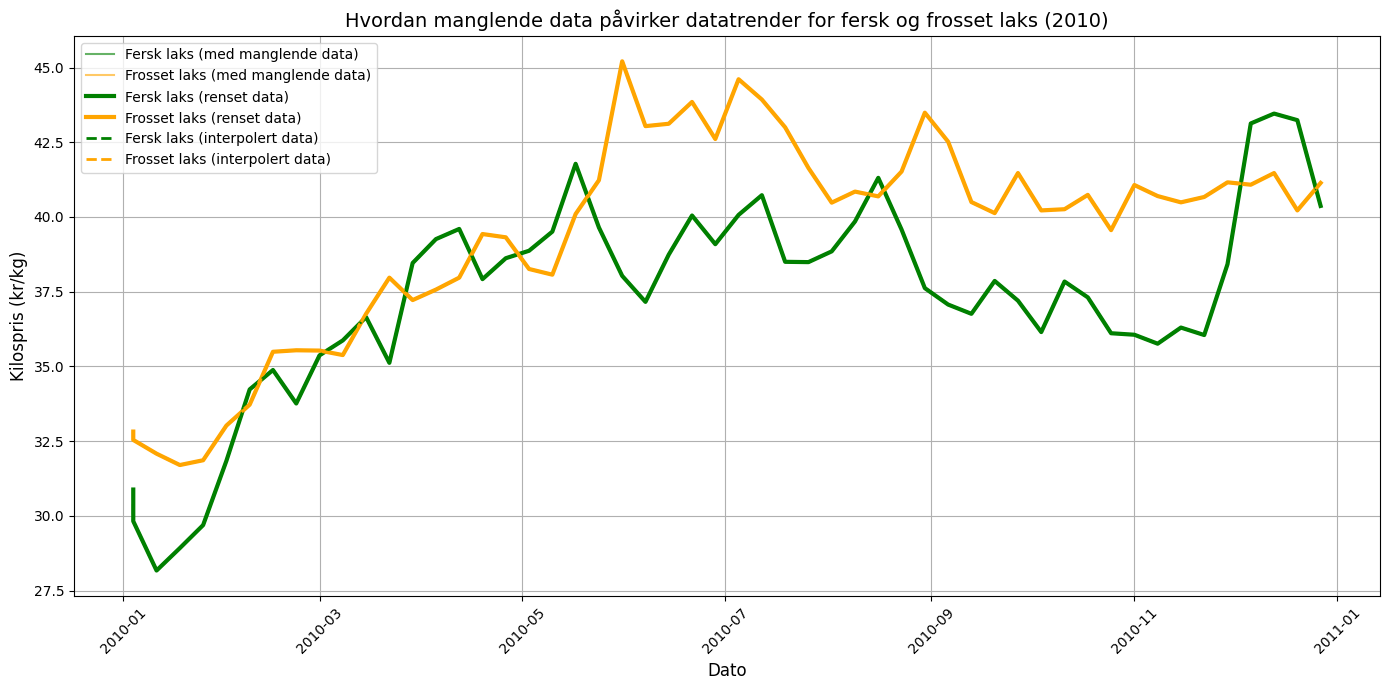

In [14]:
def manglende_data_påvirkning_ett_år(år):
    df = hent_eksportdata()

    # Konverter ukeID til mandagsdato i hver uke
    df["UkeDato"] = pd.to_datetime(df["UkeID"] + "-1", format="%Y-%W-%w")
    
    # Filtrer dataene for det spesifikke året
    df_år = df[df["UkeDato"].dt.year == år]

    # Del opp datasettet i to versjoner:
    # 1. Originalt datasett (med manglende verdier)
    df_original = df_år.copy()

    # 2. Renset datasett (fjernet manglende data)
    df_renset = df_år.dropna()

    # 3. Interpolert datasett (fyller manglende verdier med interpolasjon)
    df_interpolert = df_år.copy()
    df_interpolert["Fersk laks - Kilospris"] = df_interpolert["Fersk laks - Kilospris"].interpolate()
    df_interpolert["Frosset laks - Kilospris"] = df_interpolert["Frosset laks - Kilospris"].interpolate()

    # Plot graf for sammenligning
    plt.figure(figsize=(14, 7))

    # Originaldata (med manglende verdier)
    plt.plot(df_original["UkeDato"], df_original["Fersk laks - Kilospris"], label="Fersk laks (med manglende data)", color="green", alpha=0.6, linewidth=1.5)
    plt.plot(df_original["UkeDato"], df_original["Frosset laks - Kilospris"], label="Frosset laks (med manglende data)", color="orange", alpha=0.6, linewidth=1.5)
    
    # Renset data (uten manglende verdier)
    plt.plot(df_renset["UkeDato"], df_renset["Fersk laks - Kilospris"], label="Fersk laks (renset data)", color="green", linewidth=3)
    plt.plot(df_renset["UkeDato"], df_renset["Frosset laks - Kilospris"], label="Frosset laks (renset data)", color="orange", linewidth=3)

    # Interpolert data (med interpolasjon for manglende verdier)
    plt.plot(df_interpolert["UkeDato"], df_interpolert["Fersk laks - Kilospris"], label="Fersk laks (interpolert data)", color="green", linestyle="--", linewidth=2)
    plt.plot(df_interpolert["UkeDato"], df_interpolert["Frosset laks - Kilospris"], label="Frosset laks (interpolert data)", color="orange", linestyle="--", linewidth=2)

    # Legg til akser og tittel
    plt.xlabel("Dato", fontsize=12)
    plt.ylabel("Kilospris (kr/kg)", fontsize=12)
    plt.title(f"Hvordan manglende data påvirker datatrender for fersk og frosset laks ({år})", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    # Juster aksene for bedre visning
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Kjør funksjonen for manglende data påvirkning for et spesifikt år (f.eks. 2010)
manglende_data_påvirkning_ett_år(2010)
